# HOML CHAPTER 3 NOTES
# ~~ Classification Intro~~

## DATASET DETAILS
### MNIST
- 70,000 Images shuffled and 'split'
- First 60,000 pre-set for training
- Next 10,000 for testing

In [40]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) #fetch_openml returns pandasdf by default unless as_frame=False
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [41]:
X, y = mnist['data'], mnist['target']
print(type(mnist))
print(type(X))
print(X.shape)
# Each image has 784 features, 784=28*28px wide. Each feature represents a pixel's intensity (0-255)

<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'>
(70000, 784)


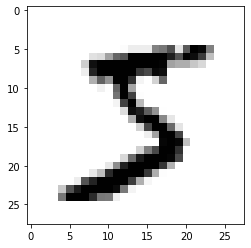

<class 'numpy.uint8'>
5


In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] #WILL FAIL IF X IS DF
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary') #colormap
# plt.axis("off")
plt.show()
# Check the label 'target' column of the mnist set
print(type(y[0]))
# Convert y into integers to avoid errors later on
y = y.astype(np.uint8)
print(y[0])

### SHUFFLING THE DATASET
For the dataset to be effective, the dataset is shuffled. This is not applicable for time-series classification jobs, however.  
This is because some algorithms are sensitive to the order of training instances. They may perform badly if trained with many similar instances in a row.  



In [48]:
# Split the data into a test set and training set.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## BINARY CLASSIFIER
Classify X and NOT-X

### SGDC: Stochastic Gradient Descent Classifier
Verbatim from the book: SGDC 
- Efficiently handles large datasets
- As it deals with training data independently
- Good online learner

In [49]:
# Create a new list of labels. If the number is '5', the label is True
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [50]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Validate the fitting
sgd_clf.predict([some_digit])


array([ True])

## PERFORMANCE MEASURES (CLASSIFICATION)
Classification models are more difficult to evaluate. These are some performance measures to evaluate them.
### CROSS VALIDATION
### CONFUSION MATRIX
### PRECISION AND RECALL
### ROC CURVE
### MULTICLASS CLASSIFICATION
### ERROR ANALYSIS

### CROSS VALIDATION
- Similar to Chp 2
WARNING: High accuracy may be due to inherent probability, not due to model accuracy.
Accuracy as a measure is not reccomended for Classification Models, especially with skewed datasets like this one.  
The skew comes from certain classes (5/!5) being more frequent than others

For a NOT-5 classifier...
- 90% accuracy is as good as guessing randomly since 1 in 10 images are a '5'.

In [51]:
 from sklearn.model_selection import cross_val_score
 cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [53]:
# Demonstration of accuracy != good model using a 'bad model'
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
#endclass
never5clf = Never5Classifier()
cross_val_score(never5clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### CONFUSION MATRIX
Count the number of times A is counted as !A/B.

The sklearn confusion matrix returns a matrix whereby:
- Row -> actual class
- Col -> predicted class  

We can use other metrics to quanitfy effectiveness. 
Precision -> how many correct?
Recall -> how many missed?
F1 Score-> how similar are precision & recall?

<u>PRECISION</u>  
Let True-pos = TP, False-pos = FP  
precison = TP/(TP+FP)

<u>RECALL</u>  
recall = TP/(TP+FN)  
^ measures the true positive rate

<u>F1 SCORE</u>  
F1 = 2(PRECISION*RECALL)/(PRECISION+RECALL)

In [54]:
from sklearn.model_selection import cross_val_predict
y_train_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,  y_train_predictions)
# (0,0)-> non-5 correctly classified
# (0,1)-> non-5 wronglt classified as 5
# (1,0)-> 5 wrongly classified

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score
vps = precision_score(y_train_5, y_train_predictions)
vrs = recall_score(y_train_5, y_train_predictions)
f1score = f1_score(y_train_5, y_train_predictions)
print(vps)
print(vrs)
print(f1score)

0.8370879772350012
0.6511713705958311
0.7325171197343846
